In [ ]:
import pandas as pd
import numpy as np

## 난수 발생을 위한 패키지
import random
## 그래프 표현을 위해 필요한 패키지
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/뽀로로드/data(아파트시세_코랩가공)/onehotcoding(연식 결측치 대체).csv', encoding='cp949')
df.set_index('동', drop=True, inplace=True)
df.head()

,연식,층,계약일,계약일(년),계약일(월),공원,마트,버스정류장,어린이집,CCTV,...,Gu_OneHot_Encoder_용산구,Gu_OneHot_Encoder_은평구,Gu_OneHot_Encoder_종로구,Gu_OneHot_Encoder_중구,Gu_OneHot_Encoder_중랑구,Type_OneHot_Encoder_단독다가구,Type_OneHot_Encoder_아파트,Type_OneHot_Encoder_연립다세대,Type_OneHot_Encoder_오피스텔,평당전세가
동,,,,,,,,,,,,,,,,,,,,,
원효로2가,30.0,6.0,20200810.0,2020,8,0.0,0.0,7.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,748.978665
원효로2가,12.0,3.0,20200921.0,2020,9,0.0,0.0,7.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1396.825397
원효로2가,1.0,5.0,20200225.0,2020,2,0.0,0.0,7.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2997.981157
원효로2가,1.0,4.0,20200210.0,2020,2,0.0,0.0,7.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3031.062124
원효로2가,2.0,5.0,20200111.0,2020,1,0.0,0.0,7.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1902.358898


In [ ]:
X_features = df.iloc[:, :-1]
y_label = df.iloc[:, -1]
train_X, test_X, train_y, test_y = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

def RMSE(y_test, y_pred):
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    return rmse

def rmse_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    rmse_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse = RMSE(y_test, pred)
        rmse_list.append(rmse)
    return model_name, rmse_list

def print_rmse_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = rmse_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} RMSLE: {r:.4f}')
    print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb


reg = LinearRegression(n_jobs=-1)
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha = 0.01, random_state=1)
Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)
DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)
rf = RandomForestRegressor(n_estimators=500, criterion='squared_error', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1, n_jobs=-1)
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, min_child_weight=5, gamma=0.1, n_jobs=-1)
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)

In [ ]:
models = []
scores = []
for model in [reg, ridge, lasso, Enet, DTree, rf, model_xgb, model_lgb]:
    model_name, mean_score = print_rmse_score(model)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations...: 100%|██████████| 10/10 [00:36<00:00,  3.64s/it]


1 FOLDS: LinearRegression RMSLE: 754.8482
2 FOLDS: LinearRegression RMSLE: 759.9889
3 FOLDS: LinearRegression RMSLE: 750.0219
4 FOLDS: LinearRegression RMSLE: 752.2216
5 FOLDS: LinearRegression RMSLE: 754.5106
6 FOLDS: LinearRegression RMSLE: 751.1392
7 FOLDS: LinearRegression RMSLE: 756.3911
8 FOLDS: LinearRegression RMSLE: 748.6199
9 FOLDS: LinearRegression RMSLE: 746.8033
10 FOLDS: LinearRegression RMSLE: 749.9431

LinearRegression mean RMSLE: 752.4488


Ridge Cross Validations...: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


1 FOLDS: Ridge RMSLE: 754.8670
2 FOLDS: Ridge RMSLE: 759.9948
3 FOLDS: Ridge RMSLE: 750.0498
4 FOLDS: Ridge RMSLE: 752.2250
5 FOLDS: Ridge RMSLE: 754.5255
6 FOLDS: Ridge RMSLE: 751.1526
7 FOLDS: Ridge RMSLE: 756.3943
8 FOLDS: Ridge RMSLE: 748.6335
9 FOLDS: Ridge RMSLE: 746.8059
10 FOLDS: Ridge RMSLE: 749.9494

Ridge mean RMSLE: 752.4598


Lasso Cross Validations...: 100%|██████████| 10/10 [18:03<00:00, 108.31s/it]


1 FOLDS: Lasso RMSLE: 754.8721
2 FOLDS: Lasso RMSLE: 759.9981
3 FOLDS: Lasso RMSLE: 750.0662
4 FOLDS: Lasso RMSLE: 752.2338
5 FOLDS: Lasso RMSLE: 754.5441
6 FOLDS: Lasso RMSLE: 751.1712
7 FOLDS: Lasso RMSLE: 756.4092
8 FOLDS: Lasso RMSLE: 748.6564
9 FOLDS: Lasso RMSLE: 746.8196
10 FOLDS: Lasso RMSLE: 749.9693

Lasso mean RMSLE: 752.4740


ElasticNet Cross Validations...: 100%|██████████| 10/10 [09:17<00:00, 55.76s/it]


1 FOLDS: ElasticNet RMSLE: 764.8034
2 FOLDS: ElasticNet RMSLE: 768.4122
3 FOLDS: ElasticNet RMSLE: 760.2613
4 FOLDS: ElasticNet RMSLE: 761.8971
5 FOLDS: ElasticNet RMSLE: 764.4220
6 FOLDS: ElasticNet RMSLE: 760.6275
7 FOLDS: ElasticNet RMSLE: 766.1555
8 FOLDS: ElasticNet RMSLE: 758.2021
9 FOLDS: ElasticNet RMSLE: 755.4531
10 FOLDS: ElasticNet RMSLE: 759.3895

ElasticNet mean RMSLE: 761.9624


DecisionTreeRegressor Cross Validations...: 100%|██████████| 10/10 [00:40<00:00,  4.02s/it]


1 FOLDS: DecisionTreeRegressor RMSLE: 733.2103
2 FOLDS: DecisionTreeRegressor RMSLE: 741.6352
3 FOLDS: DecisionTreeRegressor RMSLE: 726.7769
4 FOLDS: DecisionTreeRegressor RMSLE: 730.0680
5 FOLDS: DecisionTreeRegressor RMSLE: 738.3667
6 FOLDS: DecisionTreeRegressor RMSLE: 729.7732
7 FOLDS: DecisionTreeRegressor RMSLE: 733.3114
8 FOLDS: DecisionTreeRegressor RMSLE: 725.1371
9 FOLDS: DecisionTreeRegressor RMSLE: 721.5093
10 FOLDS: DecisionTreeRegressor RMSLE: 726.3726

DecisionTreeRegressor mean RMSLE: 730.6161


RandomForestRegressor Cross Validations...: 100%|██████████| 10/10 [4:42:47<00:00, 1696.71s/it]


1 FOLDS: RandomForestRegressor RMSLE: 651.3815
2 FOLDS: RandomForestRegressor RMSLE: 661.2624
3 FOLDS: RandomForestRegressor RMSLE: 650.4608
4 FOLDS: RandomForestRegressor RMSLE: 652.3821
5 FOLDS: RandomForestRegressor RMSLE: 656.6603
6 FOLDS: RandomForestRegressor RMSLE: 653.9728
7 FOLDS: RandomForestRegressor RMSLE: 659.8320
8 FOLDS: RandomForestRegressor RMSLE: 653.2650
9 FOLDS: RandomForestRegressor RMSLE: 649.7985
10 FOLDS: RandomForestRegressor RMSLE: 653.1096

RandomForestRegressor mean RMSLE: 654.2125


XGBRegressor Cross Validations...: 100%|██████████| 10/10 [10:15<00:00, 61.56s/it]


1 FOLDS: XGBRegressor RMSLE: 618.8444
2 FOLDS: XGBRegressor RMSLE: 599.6604
3 FOLDS: XGBRegressor RMSLE: 573.7835
4 FOLDS: XGBRegressor RMSLE: 559.3831
5 FOLDS: XGBRegressor RMSLE: 558.1452
6 FOLDS: XGBRegressor RMSLE: 548.7758
7 FOLDS: XGBRegressor RMSLE: 548.7658
8 FOLDS: XGBRegressor RMSLE: 542.6829
9 FOLDS: XGBRegressor RMSLE: 538.2330
10 FOLDS: XGBRegressor RMSLE: 534.4231

XGBRegressor mean RMSLE: 562.2697


LGBMRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 115935, number of used features: 45
[LightGBM] [Info] Start training from score 1973.178318
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor Cross Validations...:  10%|█         | 1/10 [00:09<01:29,  9.97s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 231870, number of used features: 45
[LightGBM] [Info] Start training from score 1970.317828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor Cross Validations...:  20%|██        | 2/10 [00:22<01:30, 11.26s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 347805, number of used features: 45
[LightGBM] [Info] Start training from score 1966.868675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor Cross Validations...:  30%|███       | 3/10 [00:37<01:33, 13.33s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number of data points in the train set: 463740, number of used features: 45
[LightGBM] [Info] Start training from score 1965.486972
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor Cross Validations...:  40%|████      | 4/10 [00:59<01:38, 16.48s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 866
[LightGBM] [Info] Number of data points in the train set: 579675, number of used features: 45
[LightGBM] [Info] Start training from score 1965.467581
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [01:25<01:39, 19.85s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number of data points in the train set: 695610, number of used features: 45
[LightGBM] [Info] Start training from score 1966.300856
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor Cross Validations...:  60%|██████    | 6/10 [01:54<01:31, 23.00s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 811545, number of used features: 45
[LightGBM] [Info] Start training from score 1966.464780
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor Cross Validations...:  70%|███████   | 7/10 [02:26<01:18, 26.17s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.229144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number of data points in the train set: 927480, number of used features: 45
[LightGBM] [Info] Start training from score 1966.805051
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor Cross Validations...:  80%|████████  | 8/10 [03:05<01:00, 30.10s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 1043415, number of used features: 45
[LightGBM] [Info] Start training from score 1966.994594
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor Cross Validations...:  90%|█████████ | 9/10 [03:48<00:34, 34.08s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.267091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 1159350, number of used features: 45
[LightGBM] [Info] Start training from score 1966.677218
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [04:37<00:00, 27.78s/it]

1 FOLDS: LGBMRegressor RMSLE: 588.3720
2 FOLDS: LGBMRegressor RMSLE: 591.7990
3 FOLDS: LGBMRegressor RMSLE: 576.3946
4 FOLDS: LGBMRegressor RMSLE: 572.6528
5 FOLDS: LGBMRegressor RMSLE: 573.7211
6 FOLDS: LGBMRegressor RMSLE: 569.6561
7 FOLDS: LGBMRegressor RMSLE: 573.4363
8 FOLDS: LGBMRegressor RMSLE: 569.6210
9 FOLDS: LGBMRegressor RMSLE: 564.8427
10 FOLDS: LGBMRegressor RMSLE: 564.4124

LGBMRegressor mean RMSLE: 574.4908


In [ ]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,LinearRegression,752.448779
1,Ridge,752.459783
2,Lasso,752.473985
3,ElasticNet,761.962359
4,DecisionTreeRegressor,730.616067
5,RandomForestRegressor,654.212487
6,XGBRegressor,562.269716
7,LGBMRegressor,574.490803


In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='vertical')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.22, 0.32)
plt.title('RMSLE', fontsize=15)
plt.show()

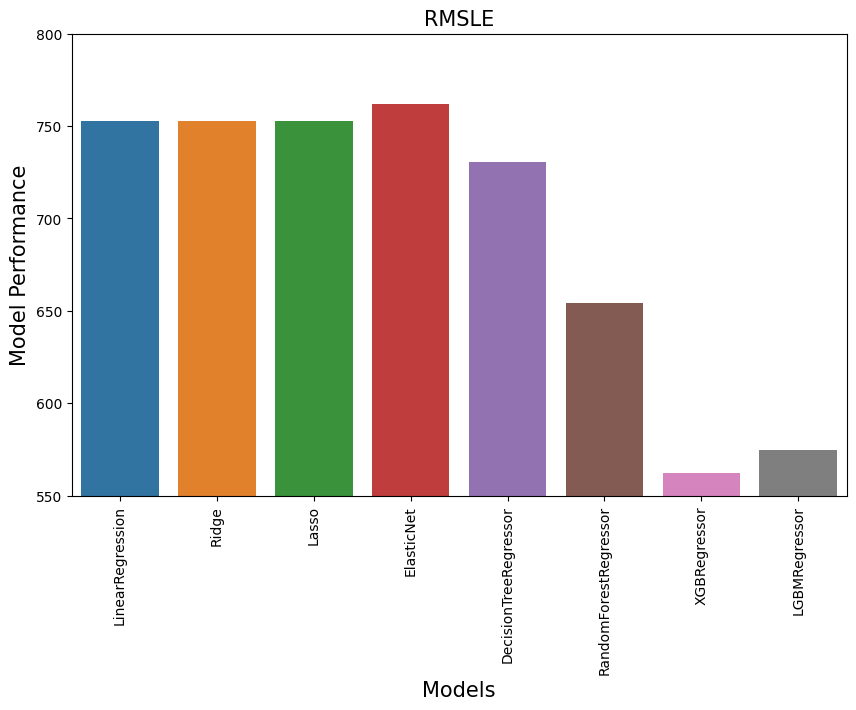

In [ ]:
result_df = pd.DataFrame({'Model':['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'DecisionTreeRegressor', 'RandomForestRegressor', 'XGBRegressor', 'LGBMRegressor'],
                         'Score':[752.448779, 752.459783, 752.473985, 761.962359, 730.616067, 654.212487, 562.269716, 574.490803]})
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='vertical')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(550, 800)
plt.title('RMSLE', fontsize=15)
plt.show()